<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE40455](https://jckantor.github.io/CBE40455) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE40455.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Extracting Information from Discrete-Event Simulations](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.05-Extracting_Information_from_Discrete-Event_Simulations.ipynb) | [Contents](toc.ipynb) | [Warehouse Fulfullment Operations](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.07-Warehouse-Fulfillment-Operations.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.06-Spankys-Pizzeria.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/02.06-Spankys-Pizzeria.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Spankys Pizzeria


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import simpy
import itertools
import random
import pandas as pd
import numpy as np

## Menu

In [2]:
menu = {
    'pizza': {'probability': 0.4, 'prep time': 0, 'cook time': 13},
    'sticks': {'probability': 0.3, 'prep time': 1, 'cook time': 10},
    'nuggets': {'probability': 0.2, 'prep time': 1, 'cook time': 10},
    'rolls': {'probability': 0.1, 'prep time': 0, 'cook time': 8}
}
menu = pd.DataFrame(menu)

items = menu.columns
probs = menu.ix['probability',:]

menu

,nuggets,pizza,rolls,sticks
cook time,10.0,13.0,8.0,10.0
prep time,1.0,0.0,0.0,1.0
probability,0.2,0.4,0.1,0.3


## Model

In [3]:
class Spanky(object):

    def __init__(self,N_SERVERS=1,N_OVENS=2,T_ORDER=10):
        self.env = simpy.Environment()
        self.server = simpy.Resource(self.env,N_SERVERS)   # server resources
        self.oven = simpy.Resource(self.env,N_OVENS)       # oven resources
        self.T_ORDER = T_ORDER
        self.data = dict()
        self.orderQueue = pd.Series([0],[0])               # track orders in progress
        self.env.process(self.orderGenerator())            # where to start the model
        
    def orderGenerator(self):
        for orderId in itertools.count():
            yield self.env.timeout(random.expovariate(1.0/self.T_ORDER))
            item = np.random.choice(items,p = probs)
            self.writeLog(orderId,item,'0 arrival')
            self.env.process(self.order(orderId,item))

    def order(self,orderId,item):
        # take order from customer
        with self.server.request() as serverreq:
            yield serverreq
            self.writeLog(orderId,item,'1 order')
            self.writeOrderQueue(+1)
            yield self.env.timeout(0.5)
            # give receipt to customer
            self.writeLog(orderId,item,'2 receipt')
            # quote finish time to customer
            tquote = self.env.now + menu[item]['prep time'] + menu[item]['cook time'] + 0.5
            self.writeLog(orderId,item,'6 tquote',tquote)
            
        # request server to prep order
        with self.server.request() as serverreq:
            yield serverreq
            self.writeLog(orderId,item,'3 prep')
            yield self.env.timeout(menu[item]['prep time'])
        
        # request oven to cook order
        with self.oven.request() as ovenreq:
            yield ovenreq
            # request server to load oven
            with self.server.request() as serverreq:
                yield serverreq
                yield self.env.timeout(0.25)
                self.writeLog(orderId,item,'4 oven') 
            # cook order
            yield self.env.timeout(menu[item]['cook time'])
            # request server to unload oven
            with self.server.request() as serverreq:
                yield serverreq
                yield self.env.timeout(0.25)
                self.writeLog(orderId,item,'5 finish')
                self.writeOrderQueue(-1)

    def writeLog(self,orderId,item,event,t=None):
        if t==None:
            t = self.env.now
        self.data[orderId,item,event] = t
        
    @property
    def log(self):
        df = pd.DataFrame([[a,b,c,self.data[a,b,c]] for (a,b,c) in self.data.keys()])
        df.columns = ['OrderID','Item','Event','Time']
        return df.pivot_table(values='Time',index=['OrderID','Item'],columns=['Event'])
    
    def stats(self):
        df = w.log
        late = df['5 finish']-df['6 tquote']
        late = late[late > 0]
        
        N = {}
        N['orders'] = df[df['1 order']>0]['1 order'].count()
        N['finished'] = df[df['5 finish']>0]['5 finish'].count()
        N['late'] = late.count()
        N['latefrac'] = N['late']/N['orders']
        N['meanlate'] = late.mean()
        N['maxlate'] = late.max()
        
        print(" Orders Received = {0:6d}".format(N['orders']))
        print(" Orders Finished = {0:6d}".format(N['finished']))
        print("     Late Orders = {0:6d}".format(N['late']))
        print("   Fraction late = {0:6.3f}".format(N['latefrac']))
        print("Average lateness = {0:6.3f}".format(N['meanlate']))
        print("Maximum lateness = {0:6.3f}".format(N['maxlate']))
        
        plt.subplot(2,1,1)
        late.hist()
        plt.title('Distribution of Late Orders')
        plt.ylabel('Number of orders')
        plt.xlabel('Minutes late')
        plt.subplot(2,1,2)
        w.orderQueue.plot()
        plt.xlabel('Time [min]')
        plt.ylabel('Orders')
        plt.title('Orders in Process')
        plt.tight_layout()

        return N

    def writeOrderQueue(self,inc):                         # track orders in progress
        self.orderQueue[self.env.now] = self.orderQueue.iloc[-1] + inc
                    
    def run(self,t_sim):
        self.env.run(until=t_sim)

## Simulation of Existing Operations

 Orders Received =     17
 Orders Finished =     17
     Late Orders =      8
   Fraction late =  0.471
Average lateness =  1.635
Maximum lateness =  5.738


{'finished': 17,
 'late': 8,
 'latefrac': 0.47058823529411764,
 'maxlate': 5.7380732432047523,
 'meanlate': 1.635408416738107,
 'orders': 17}

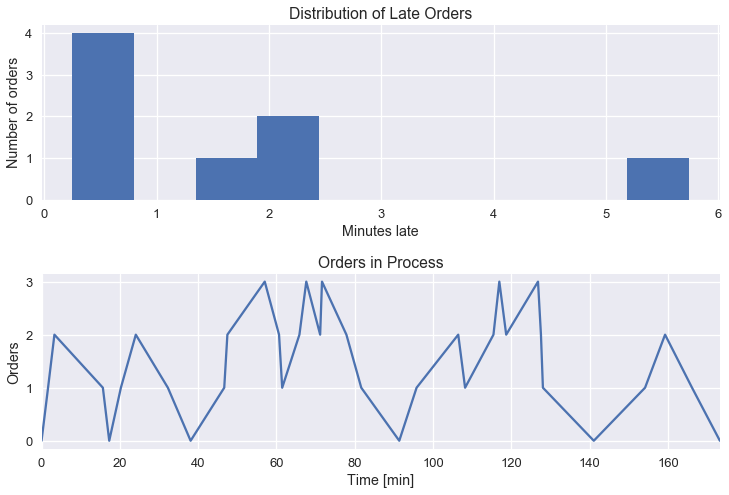

In [6]:
# create Spanky's with one server, two ovens, with orders arriving at an average of 10 minutes
w = Spanky(1,2,10)

# run a simulation for 180 minutes
w.run(180)

# summarize data
w.stats()

## Should Spanky's add additional ovens?

## Should Spanky's add additional servers?

<!--NAVIGATION-->
< [Extracting Information from Discrete-Event Simulations](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.05-Extracting_Information_from_Discrete-Event_Simulations.ipynb) | [Contents](toc.ipynb) | [Warehouse Fulfullment Operations](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.07-Warehouse-Fulfillment-Operations.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.06-Spankys-Pizzeria.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/02.06-Spankys-Pizzeria.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>